# Neuvisys notebook

Display multiple information from a spiking neural network experiment.

In [20]:
%load_ext autoreload
%autoreload 2

import os
import pprint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pdf2image import convert_from_path
from src.spiking_network.network.neuvisys import SpikingNetwork
from src.spiking_network.analysis.network_display import (
    display_network,
    load_array_param,
    complex_cells_directions,
)
from src.spiking_network.analysis.network_statistics import (
    rf_matching,
    compute_disparities,
    direction_norm_length,
    orientation_norm_length,
    direction_selectivity,
    orientation_selectivity,
    update_dataframe,
    disparity_histogram,
)
from src.spiking_network.analysis.spike_train import (
    spike_trains,
    raster_plot,
    event_plot,
    time_histogram,
    spike_rate_histogram,
    isi_histogram,
    instantaneous_rates,
    correlation_coeficient_matrix,
)
from src.spiking_network.gabor.gabbor_fitting import (
    create_gabor_basis,
    hists_preferred_orientations,
    plot_preferred_orientations,
)
from src.spiking_network.analysis.parameter_analysis import (
    correlation_matrix,
    scatter_mat,
)

os.chdir("/home/thomas/neuvisys-analysis/src")
home = "/home/thomas/"

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30

plt.rc('figure', figsize=(30, 8))
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE,
       labelsize=MEDIUM_SIZE)  # fontsize of the axes title, fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize

network_path = "/home/thomas/Desktop/Experiment/EXP4/network_experiment/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Network

loads various information of the spiking neural network into a SpikingNetwork instance.

In [21]:
spinet = SpikingNetwork(network_path)

## <span style="color:red">Comments about the experiment.</span>

Learning inhibitory connections:
- We learned the weights of the network on vertical and horizontal bars equally.
- We then learned the inhibitory connection on vertical bars only.
- We display here information about the network response to this simuli

## Weights analysis

Display of the learned receptive fields of the different neuronal layers

Simple cells weights


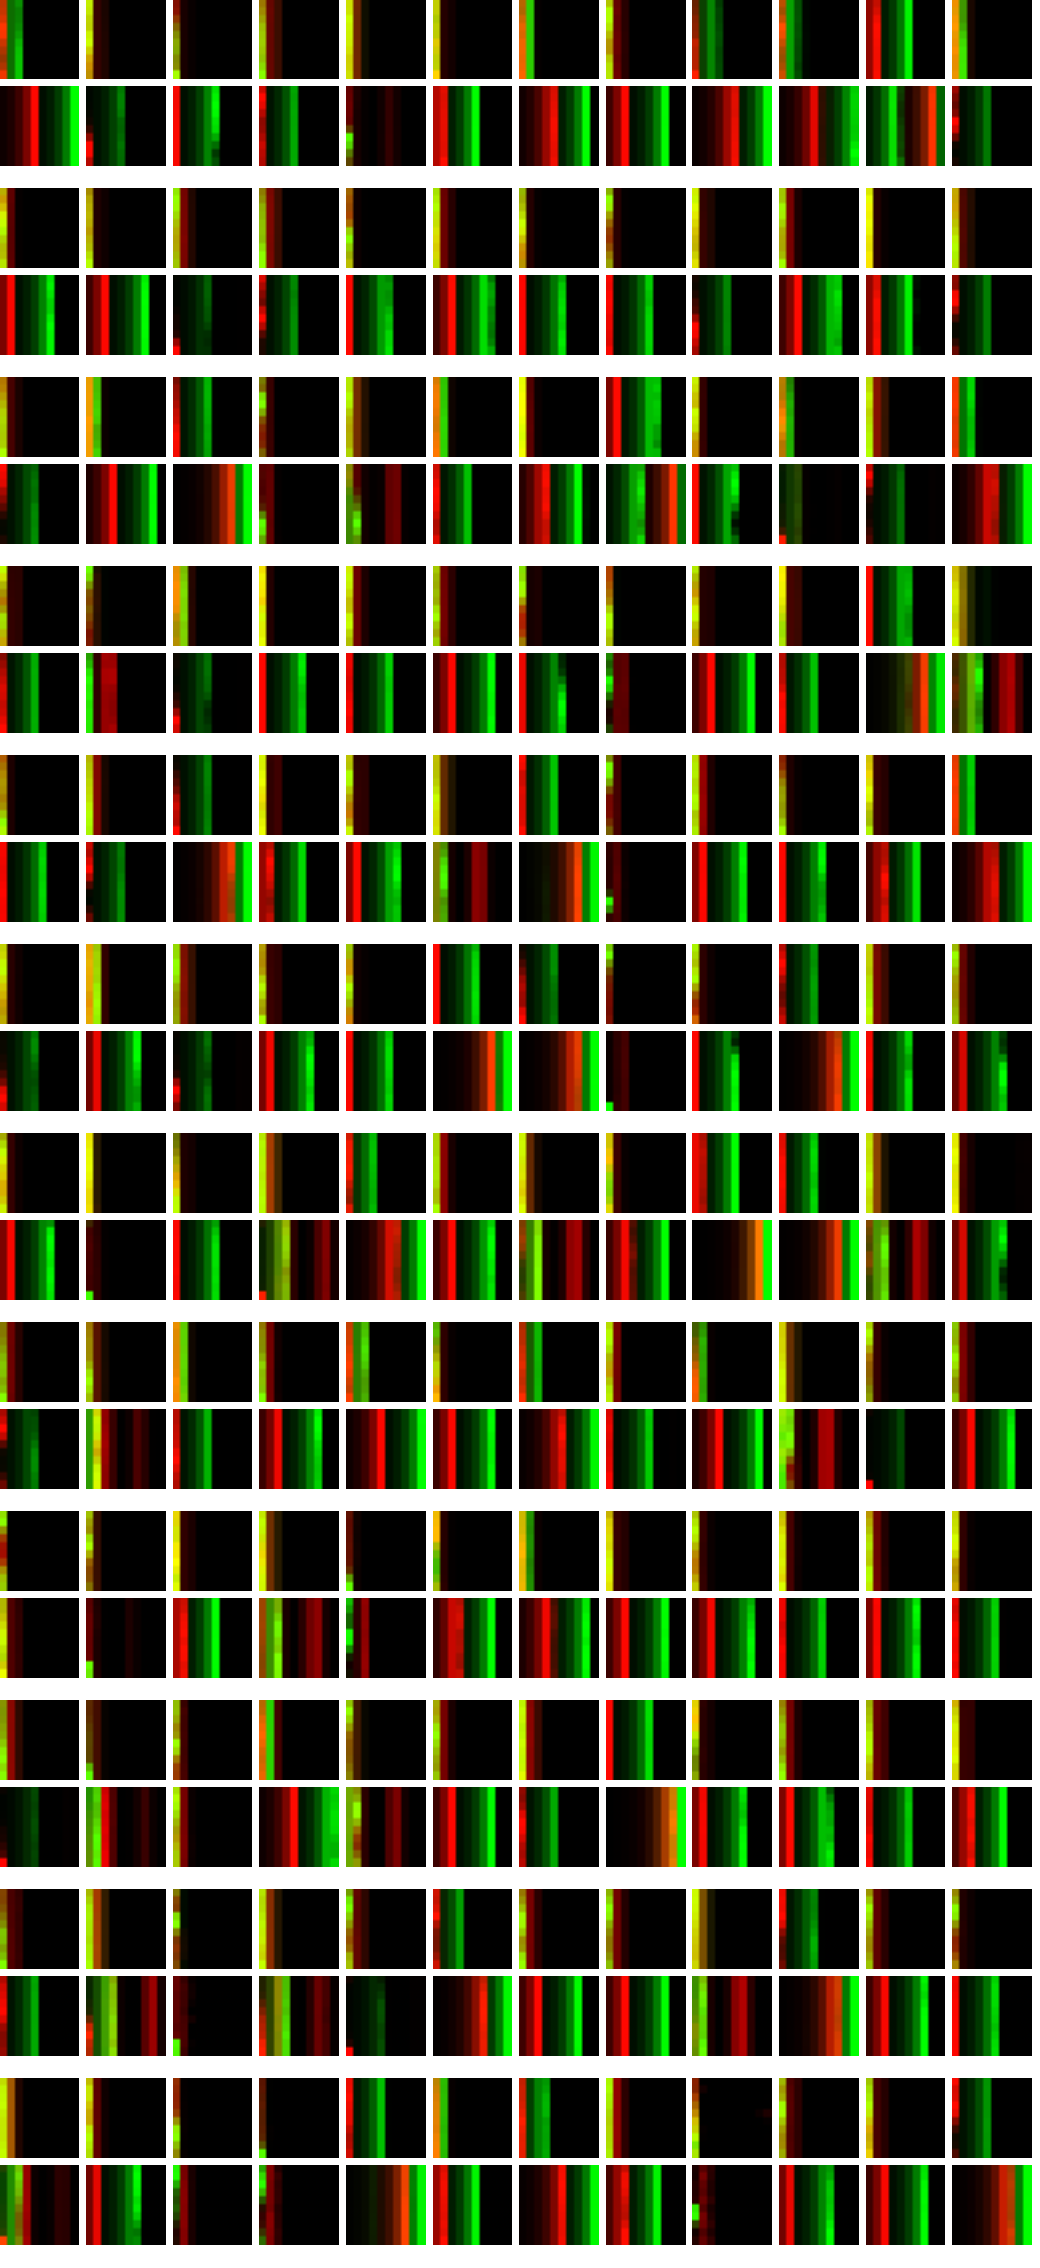

Complex cells weights (average over all simple cells)


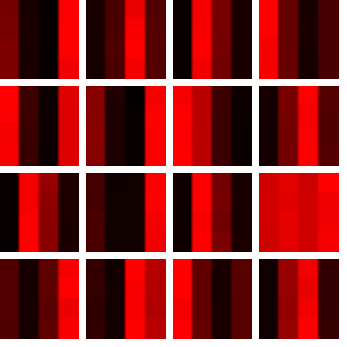

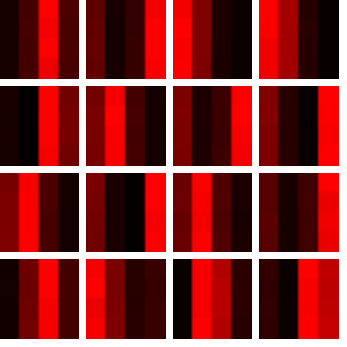

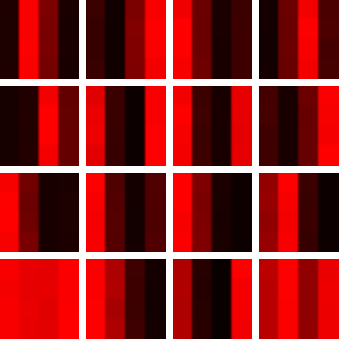

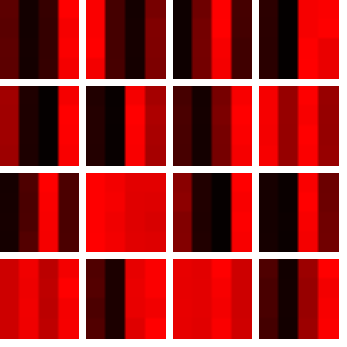

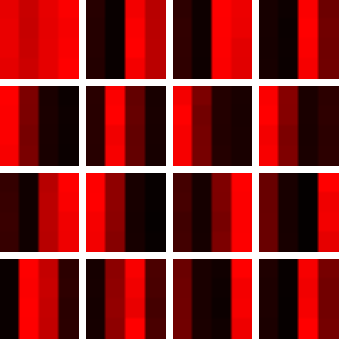

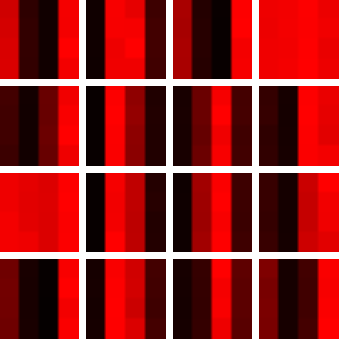

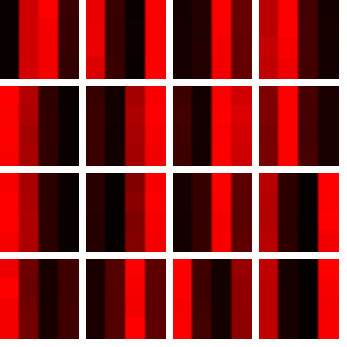

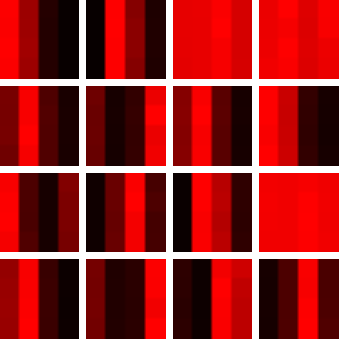

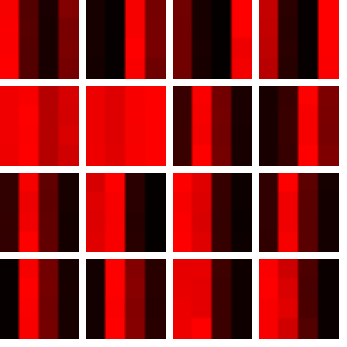

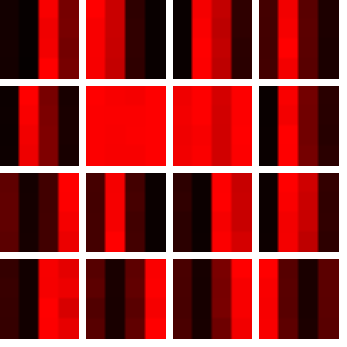

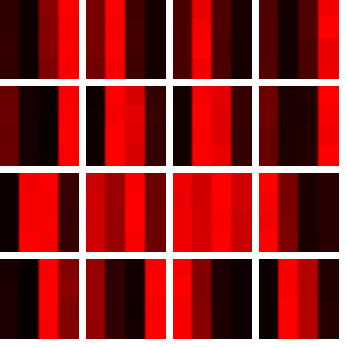

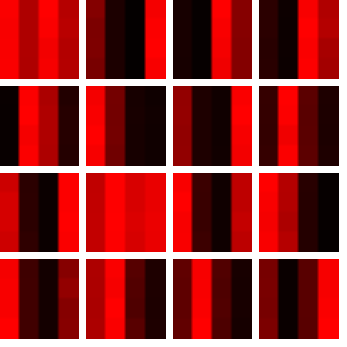

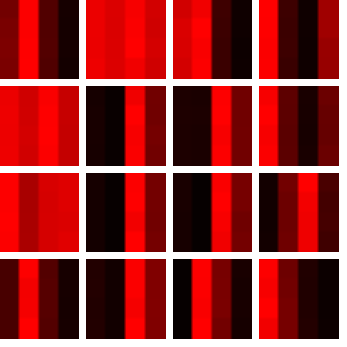

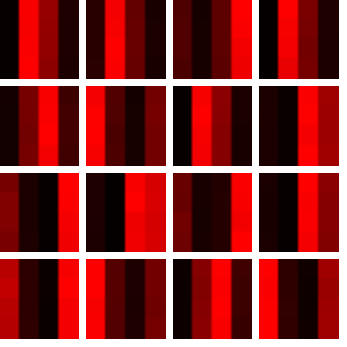

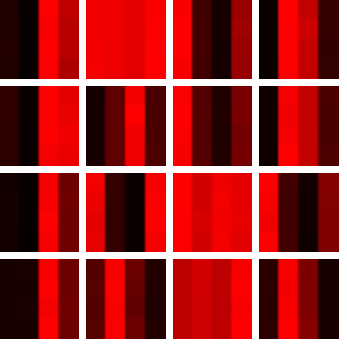

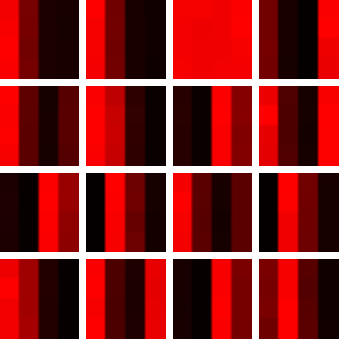

In [9]:
display_network([spinet])

print("Simple cells weights")
if spinet.conf["nbCameras"] == 2:
    display(convert_from_path(network_path + "figures/0/weight_sharing_combined.pdf")[0])
else:
    display(convert_from_path(network_path + "figures/0/weight_sharing_0.pdf")[0])

print("Complex cells weights (average over all simple cells)")
for i in range(spinet.l_shape[1, 2]):
    display(convert_from_path(network_path + "figures/1/complex_weights_depth_" + str(i) + ".pdf")[0])

## Spike analysis

Displaying information related to spike timings in the network.

This includes:
- Eventplots
- Time histograms
- Inter-spike histograms
- Raster plots
- Instantaneous rates
- Correlation coefficient matrices
- spike rate histograms

Layer 1, nb neurons = 36864:


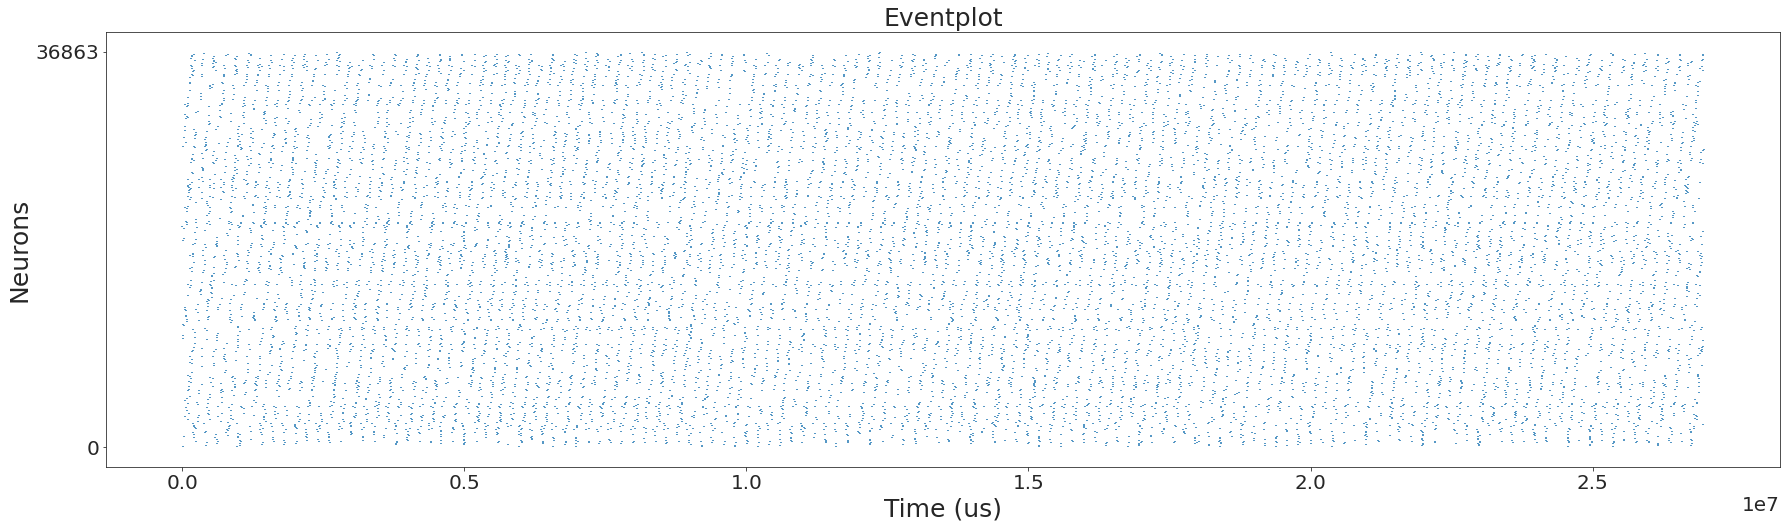

/home/thomas/miniconda3/envs/neuvisys-analysis/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 2807 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


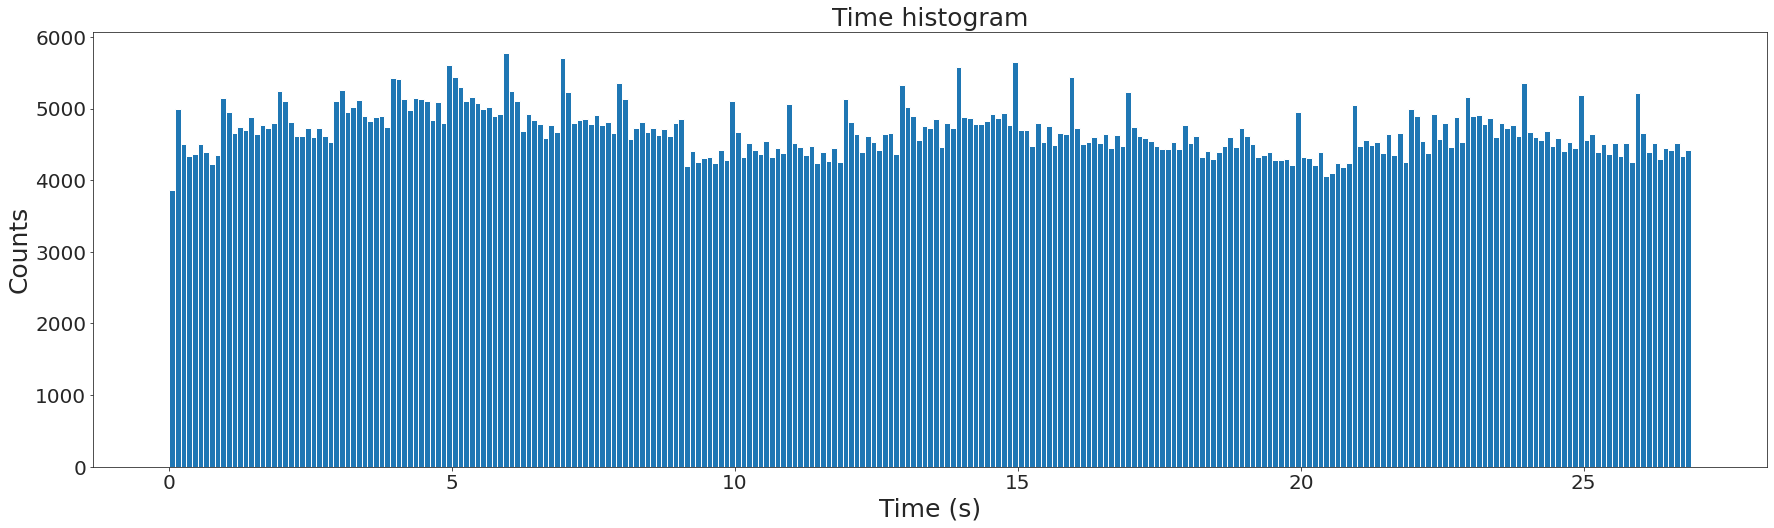

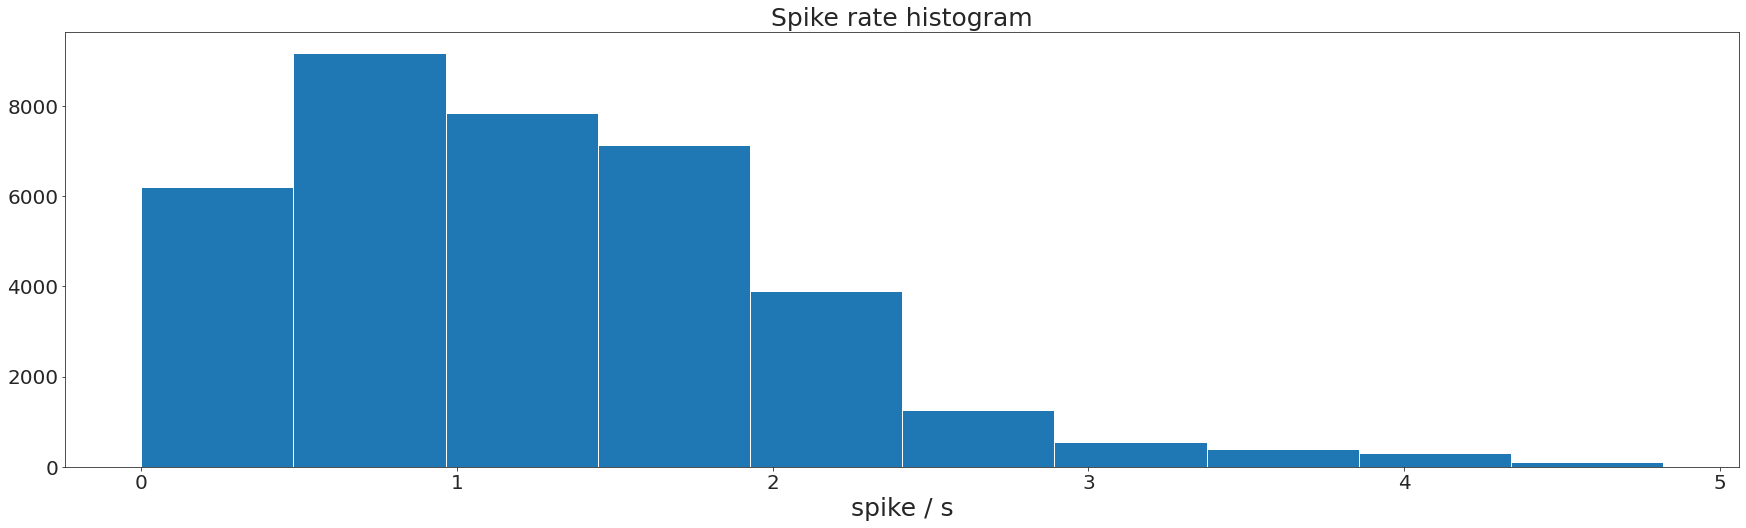

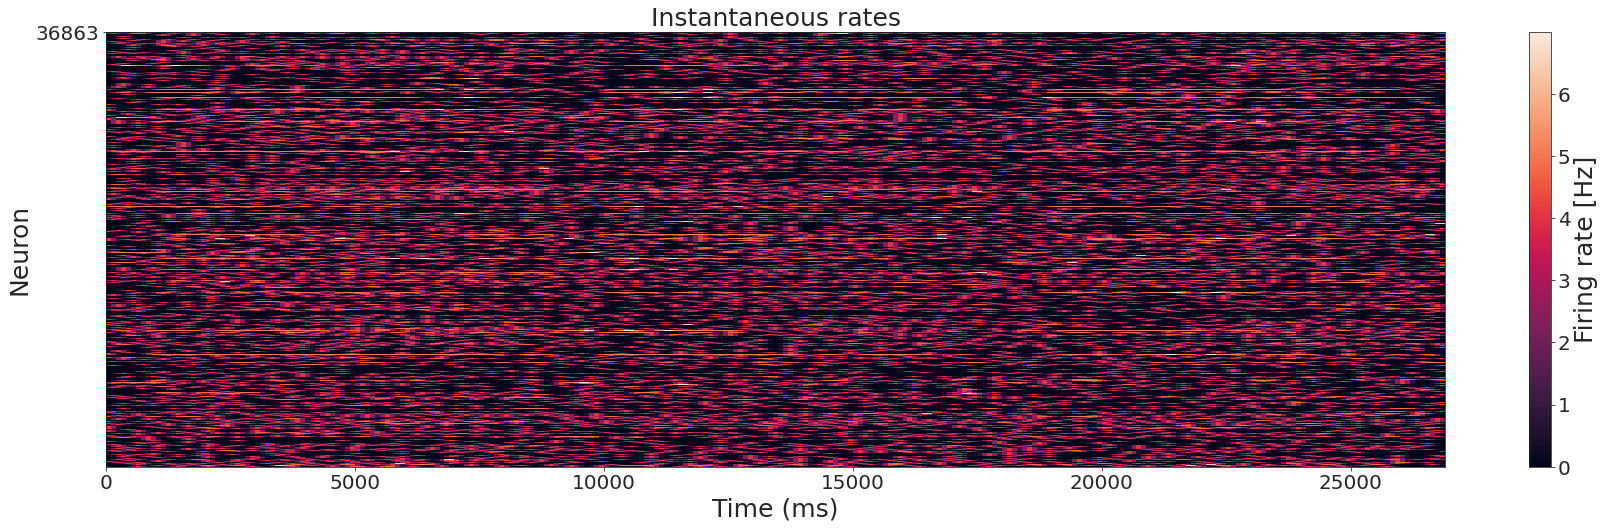

Layer 2, nb neurons = 158:


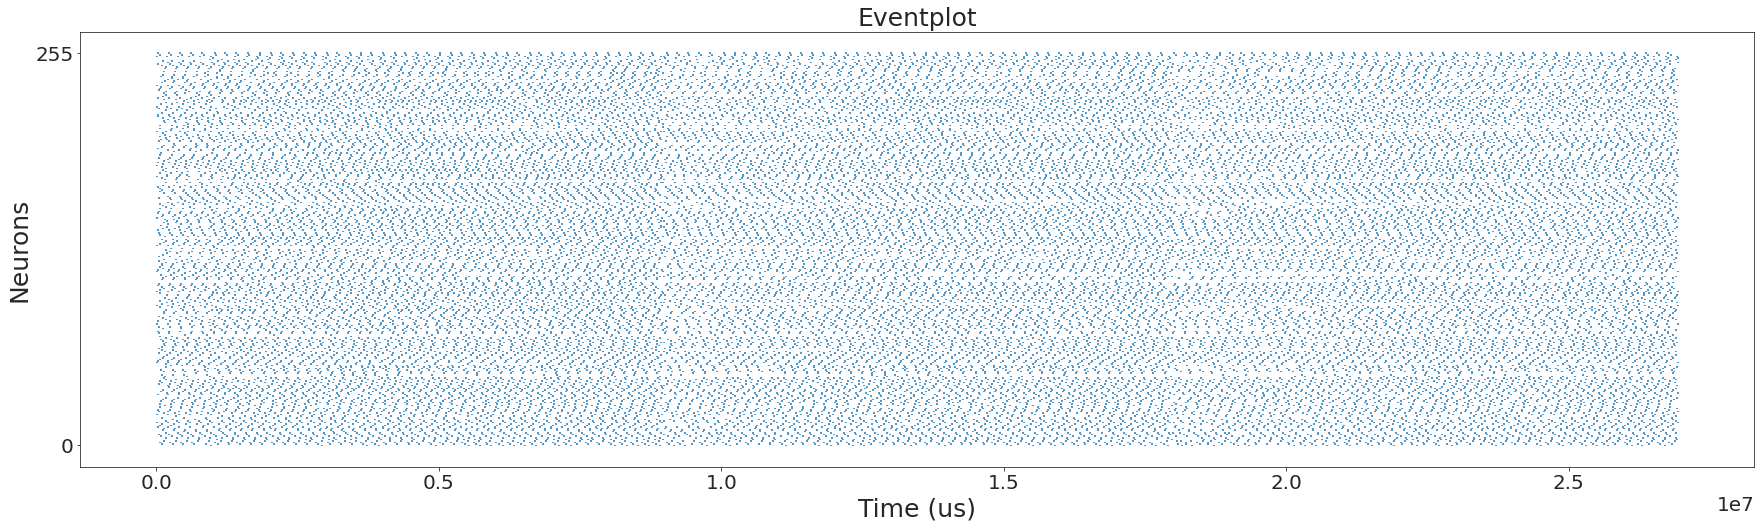

/home/thomas/miniconda3/envs/neuvisys-analysis/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 40 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


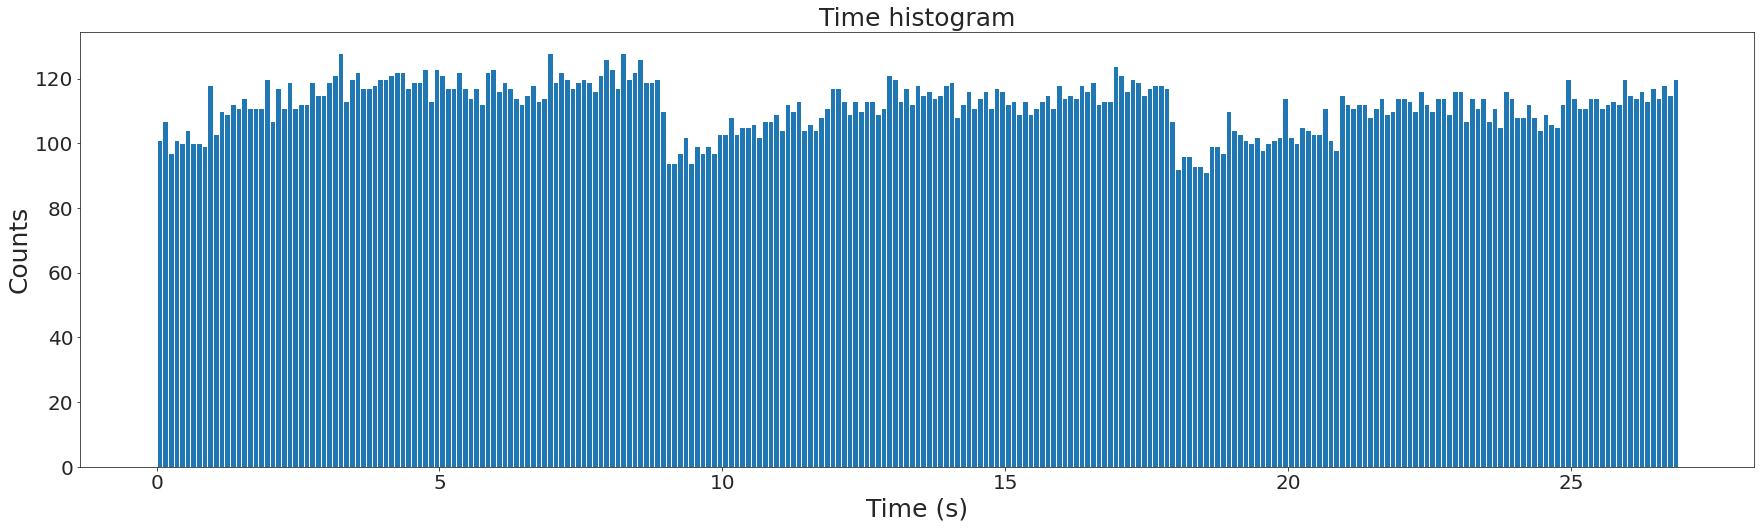

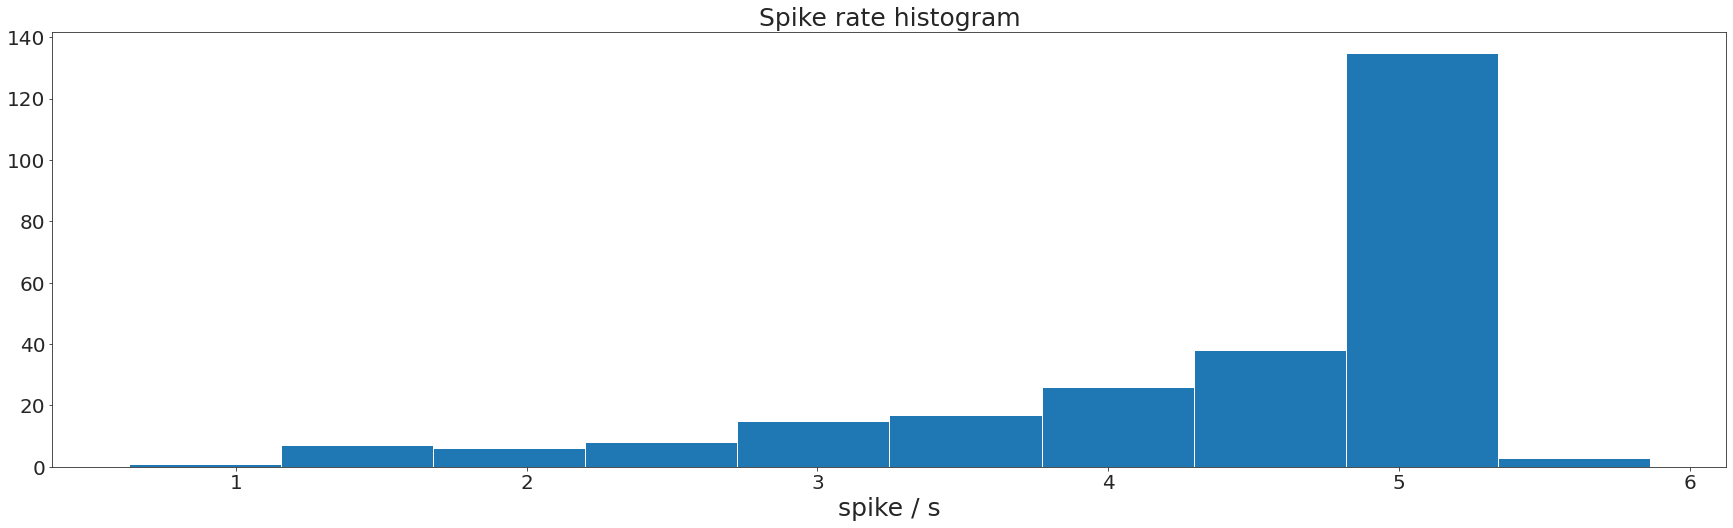

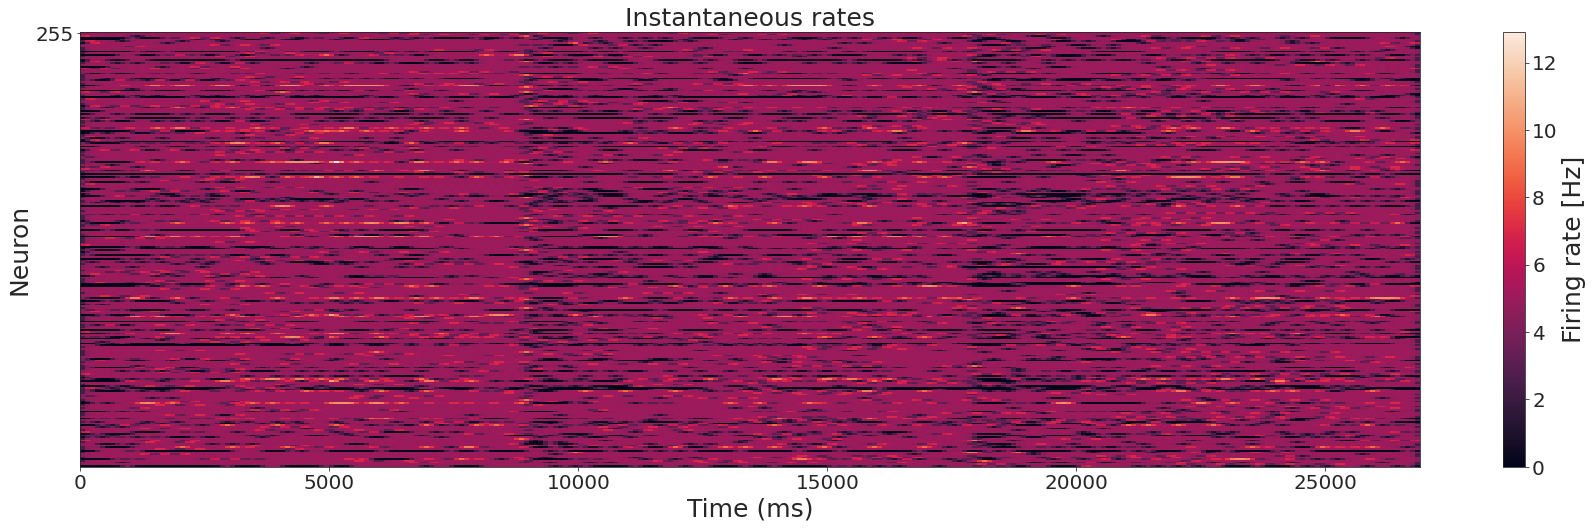

In [22]:
for layer, layer_spike_train in enumerate(spinet.spikes):
    print("Layer " + str(layer + 1) + ", nb neurons = " + str(layer_spike_train.shape[layer]) + ":")
    sts = spike_trains(layer_spike_train)
    path = network_path + "figures/"
    raster_plot(sts, layer, path)
    event_plot(sts, layer, path)
    time_histogram(sts, layer, path)
    spike_rate_histogram(layer_spike_train, layer, path)
    # isi_histogram(sts, layer, path)
    instantaneous_rates(sts, layer, path)
    # correlation_coeficient_matrix(sts, layer, path)

In [6]:
subset = slice(0, 1)
for layer, layer_spike_train in enumerate(spinet.spikes):
    print("Layer " + str(layer + 1) + ", nb neurons = " + str(layer_spike_train[subset].shape[layer]) + ":")
    sts = spike_trains(layer_spike_train[subset])
    path = network_path + "/figures/"
    event_plot(sts, layer, path)
    time_histogram(sts, layer, path)
    instantaneous_rates(sts, layer, path)

Layer 1, nb neurons = 0:


ValueError: zero-size array to reduction operation maximum which has no identity

## Compute receptive field disparities

(array([47,  0,  1, 18,  7, 17, 20,  3, 11, 20]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]))

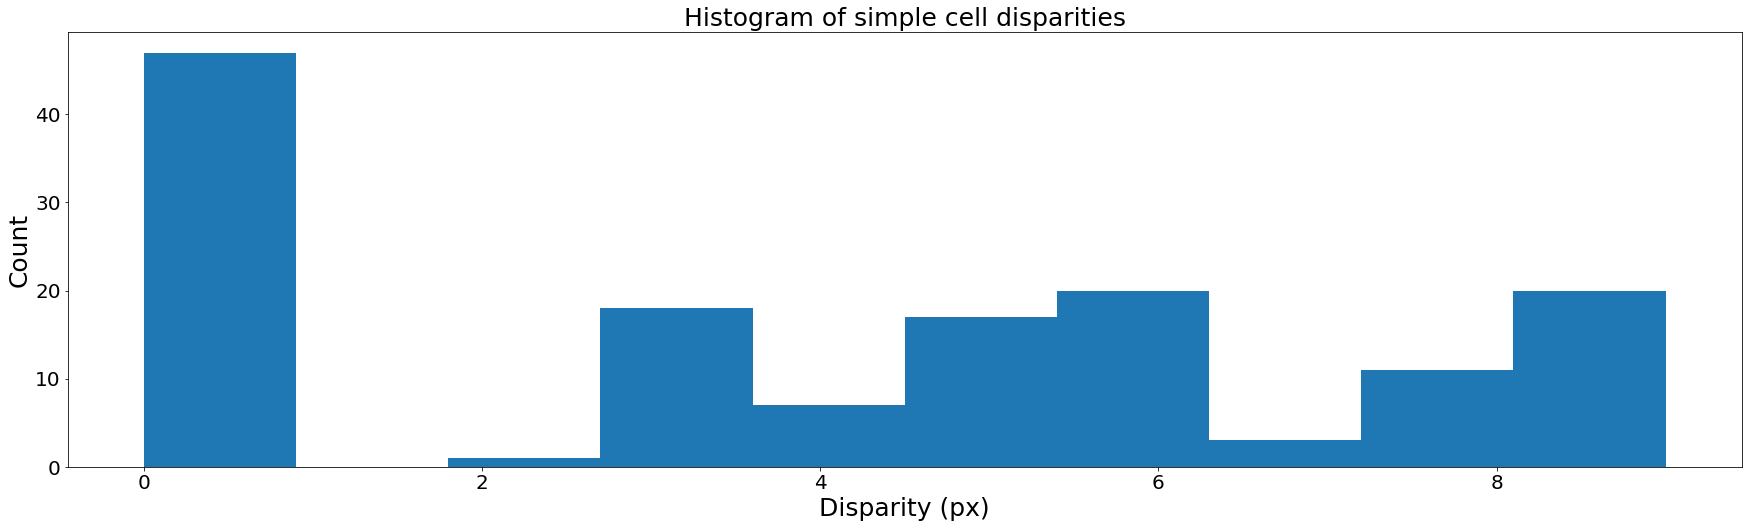

In [5]:
compute_disparities(spinet)

weights = spinet.get_weights("simple")
residuals, disparities = rf_matching(weights)
disparity_histogram(disparities)

np.histogram(disparities[:, 0])

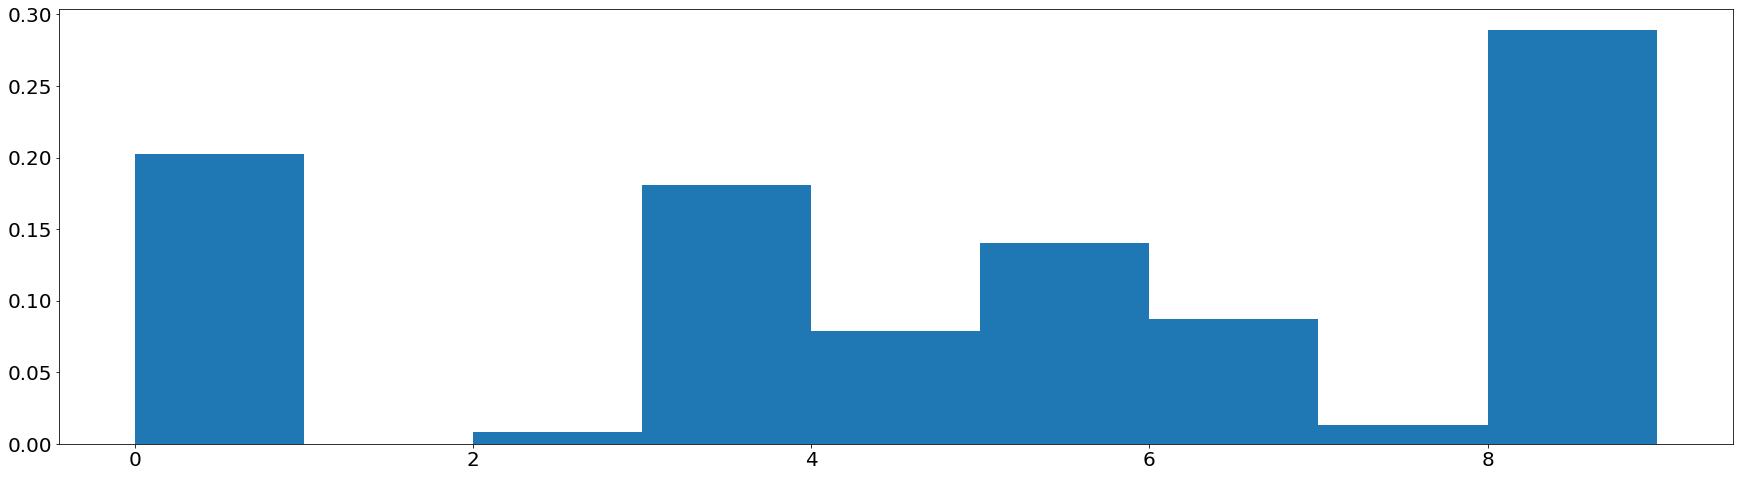

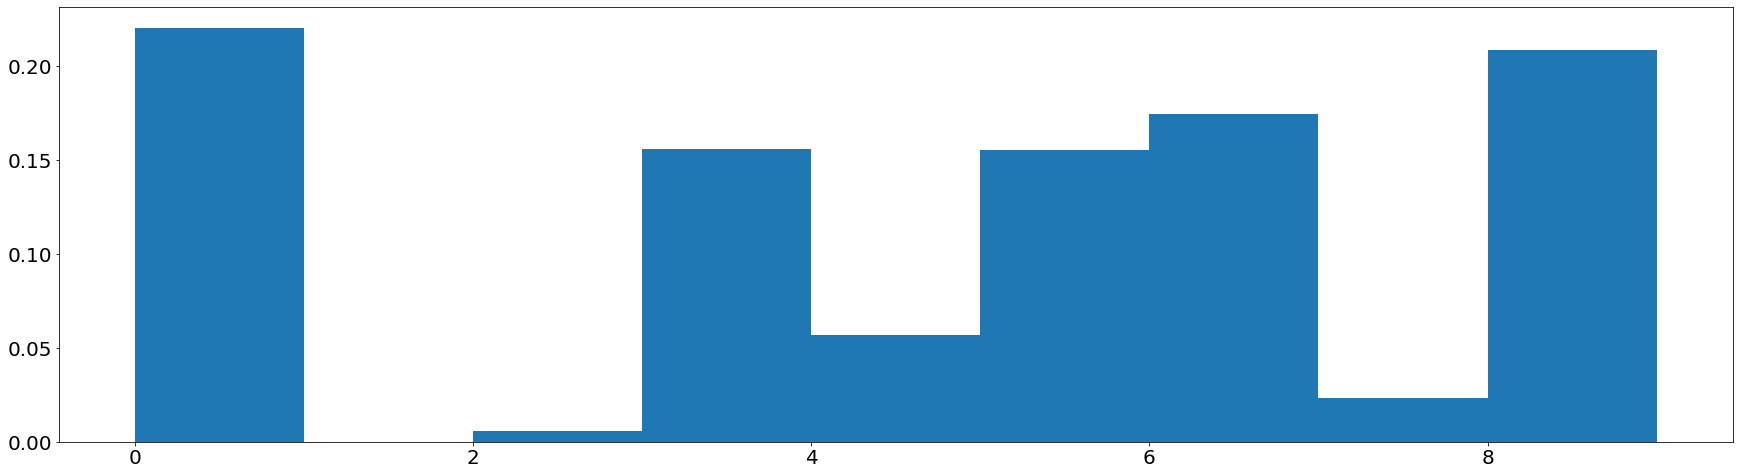

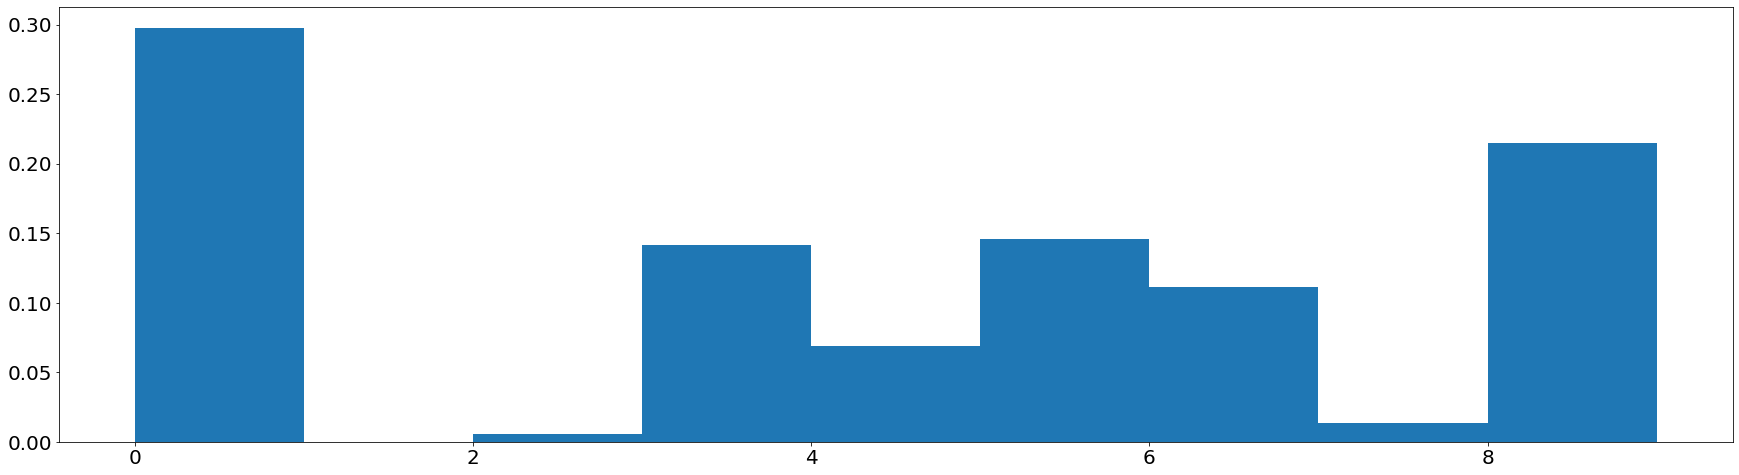

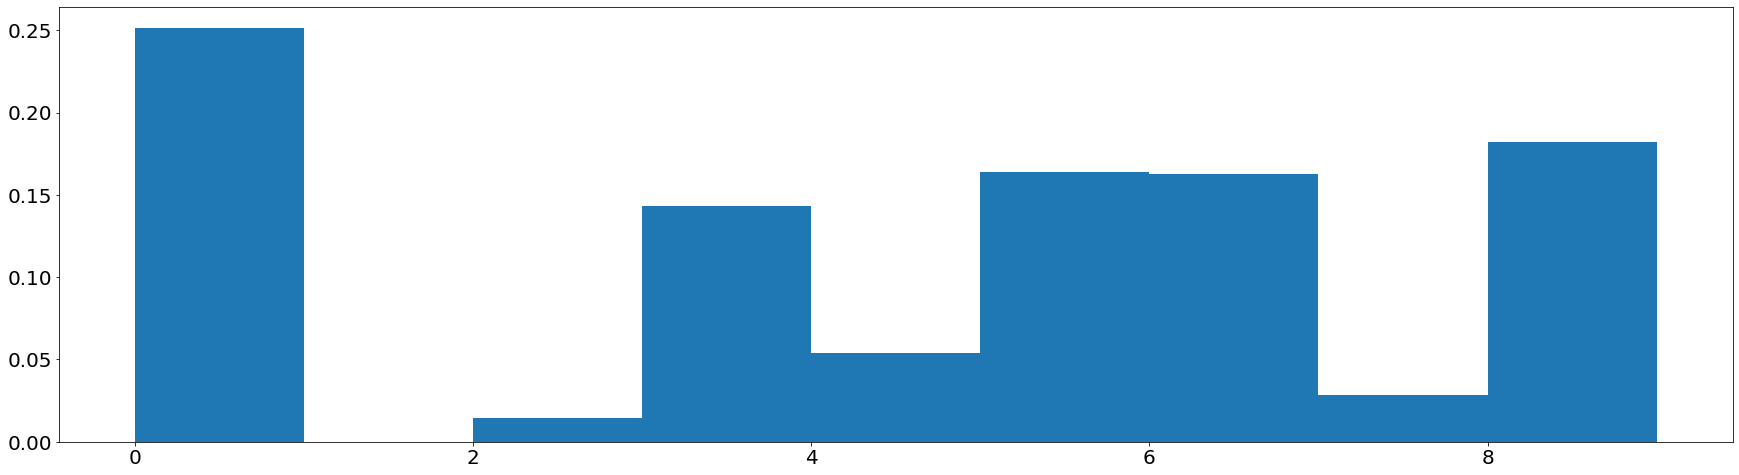

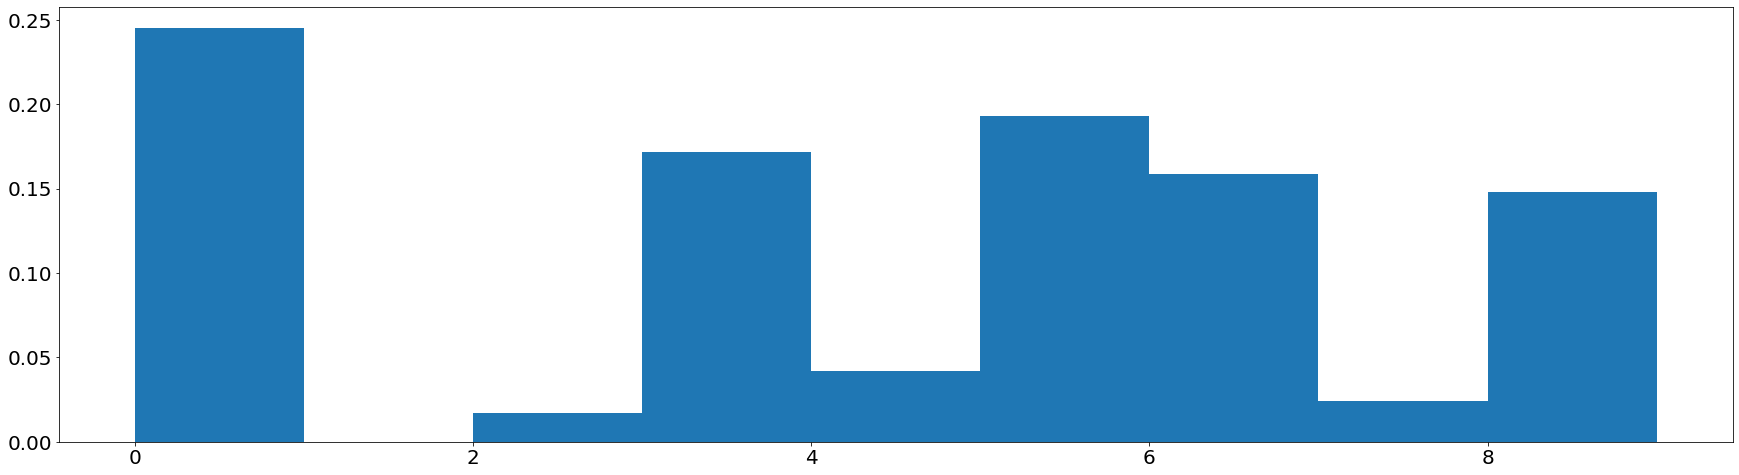

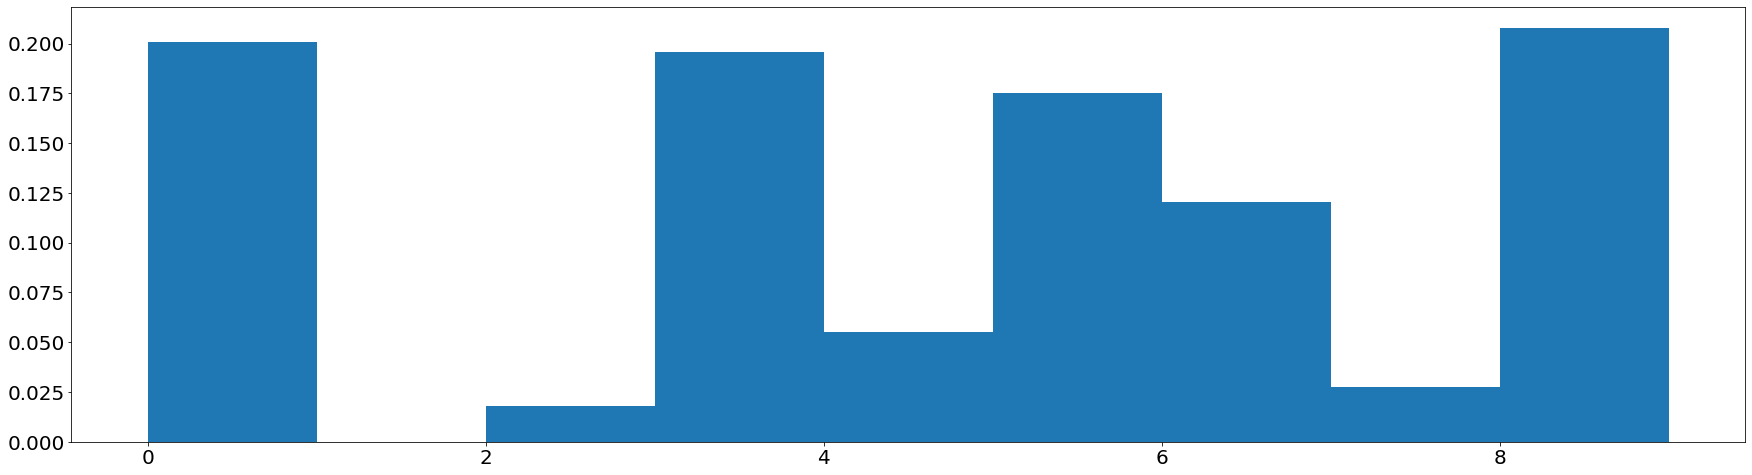

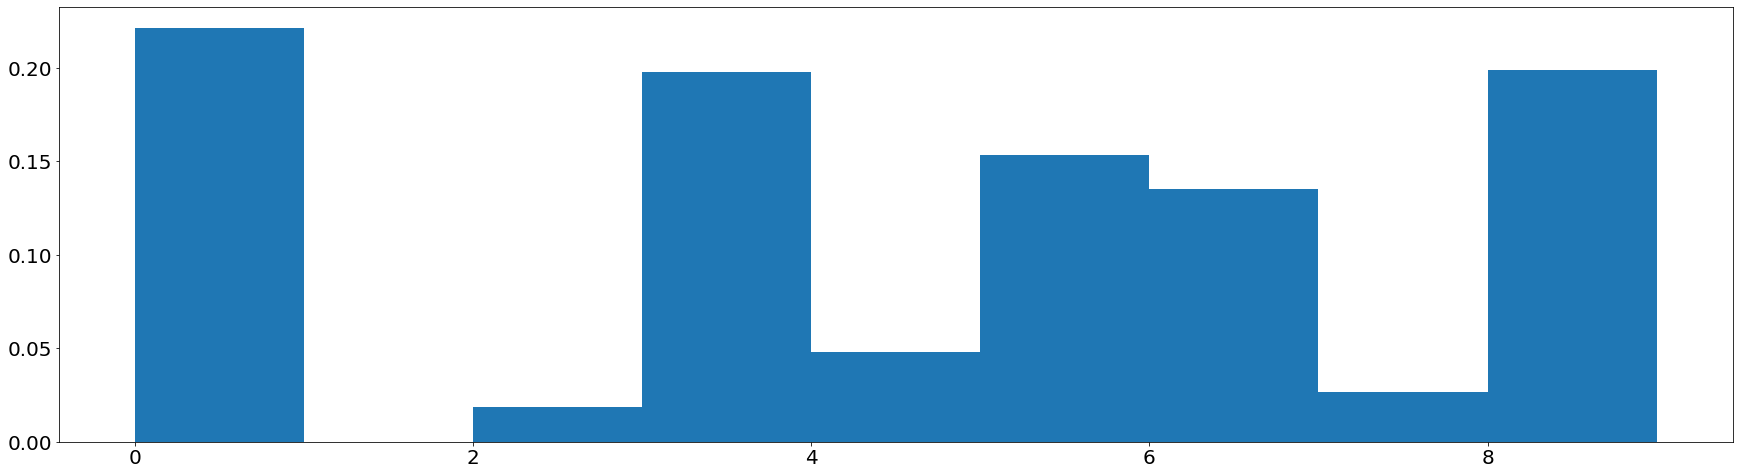

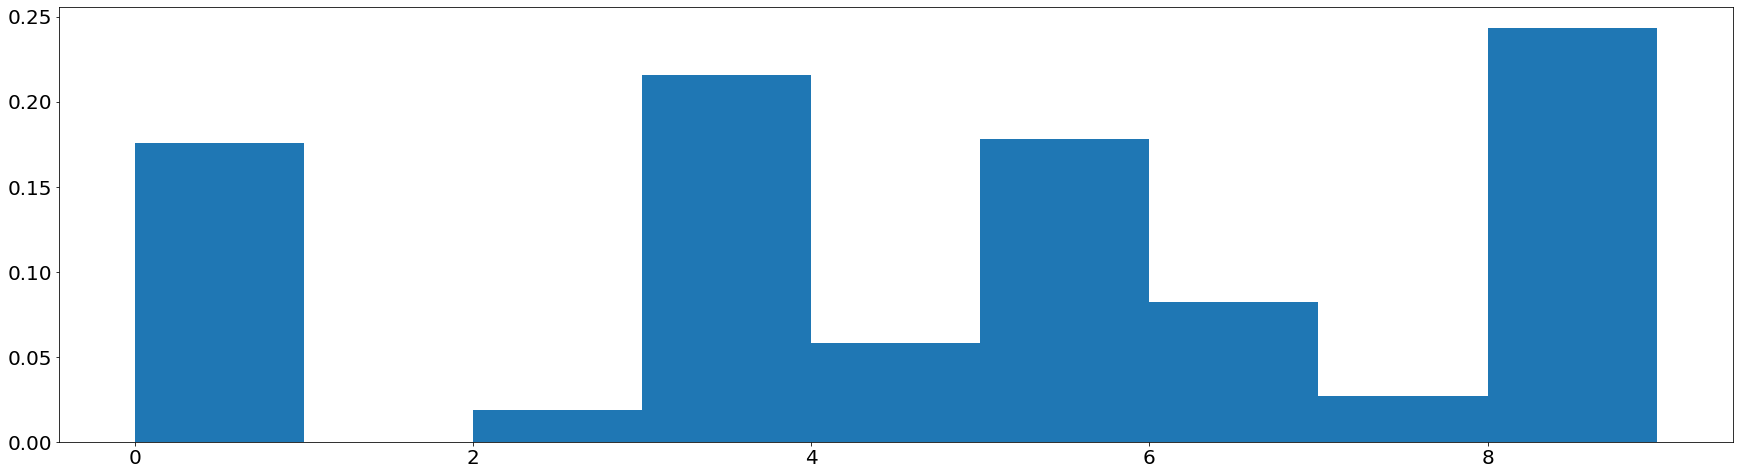

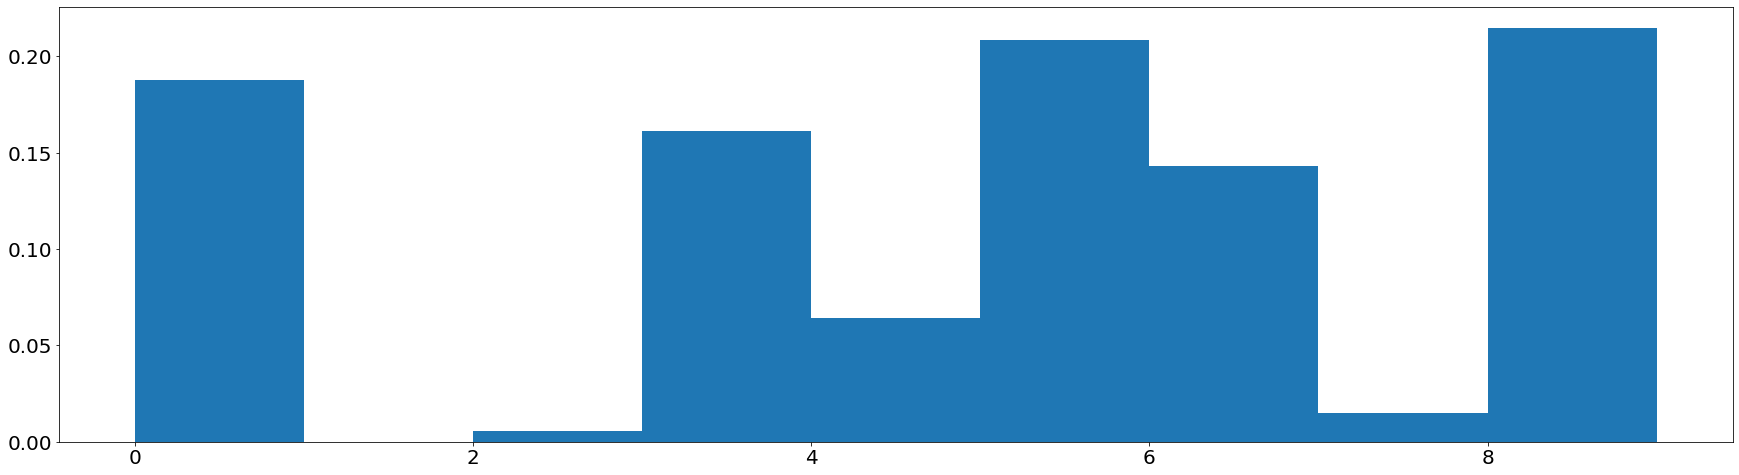

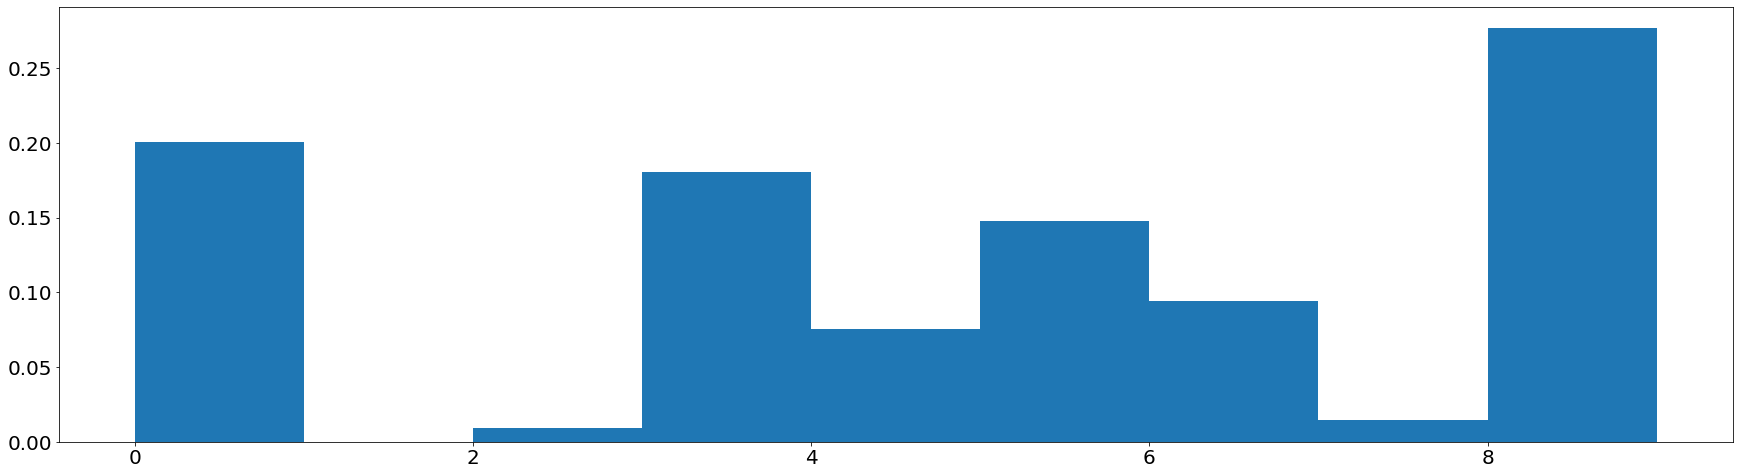

In [6]:
for i in range(0, 10):
    disp = []
    for id_neuron in spinet.neurons[1][i].params["in_connections"]:
        disp.append(spinet.neurons[0][id_neuron].disparity)
    disp = np.array(disp)
    plt.figure()
    plt.hist(disp[:, 0], weights=spinet.neurons[1][i].weights.ravel(), density=True, bins=np.arange(0, 10))

## Network training information

In [ ]:
reward = np.array(spinet.state["learning_data"]["reward"])
value = np.array(spinet.state["learning_data"]["value"])
value_dot = np.array(spinet.state["learning_data"]["valueDot"])
td_error = np.array(spinet.state["learning_data"]["tdError"])
score = np.array(spinet.state["learning_data"]["score"])
t = np.linspace(0, np.max(spinet.spikes[0]), reward.size) * 1e-6

plt.figure(figsize=(40, 8))
plt.title("Reward and value curves")
plt.xlabel("time (s)")
plt.plot(t, reward, label="reward")
plt.plot(t, value, label="value")
plt.hlines(0, 0, t[-1], linestyles="dashed")
plt.legend()
plt.show()

plt.figure(figsize=(40, 8))
plt.title("Value derivative")
plt.xlabel("time (s)")
plt.plot(t, value_dot, color="green", label="value_dot")
plt.hlines(0, 0, t[-1], linestyles="dashed")
plt.show()

plt.figure(figsize=(40, 8))
plt.title("TD error")
plt.xlabel("time (s)")
plt.plot(t, td_error, color="red", label="td_error")
plt.hlines(0, 0, t[-1], linestyles="dashed")
plt.show()

td_actions = []
for i in range(0, td_error.shape[0], 10):
    td_actions.append(np.mean(td_error[i:i + 10]))

plt.figure(figsize=(40, 8))
plt.title("mean TD error at action choice")
plt.xlabel("time (s)")
plt.plot(td_actions, color="cyan", label="td_error")
plt.hlines(0, 0, i / 10, linestyles="dashed")
plt.show()

plt.figure(figsize=(40, 8))
plt.title("Score")
plt.xlabel("time (s)")
plt.plot(10 * np.arange(0, score.shape[0]), score, color="red", label="td_error")
plt.show()

## Policy plot

In [ ]:
actions = np.array(spinet.state["learning_data"]["action"])
exploration = np.array(spinet.state["learning_data"]["exploration"])

t = np.arange(0, 10 * actions.size, 10)

classes = ["Left", "None", "Right"]
markers = ["s", "o"]

plt.figure(figsize=(40, 8))
plt.title("Actions")
plt.xlabel("time (s)")

plt.scatter(t[exploration == 0], np.zeros_like(t)[exploration == 0], c=actions[exploration == 0], marker='1',
            linewidths=15)
plt.scatter(t[exploration == 1], np.zeros_like(t)[exploration == 1], c=actions[exploration == 1], marker='s',
            linewidths=15)

plt.legend(handles=plt.scatter.legend_elements()[0], labels=classes)
plt.show()

## Critic and Actor neurons weights

In [ ]:
w = np.zeros((spinet.neurons[2][0].weights.shape[0], spinet.neurons[2][0].weights.shape[1]))
for neuron in spinet.neurons[2]:
    w += np.sum(neuron.weights, axis=2)
plt.figure(figsize=(18, 8))
plt.title("Critic neurons summed weights")
plt.imshow(w.T)
plt.colorbar(orientation="horizontal")
plt.show()

for i, neuron in enumerate(spinet.neurons[3]):
    plt.figure(figsize=(18, 8))
    if i == 0:
        plt.title("Action: camera to the left")
    else:
        plt.title("Action: camera to the right")
    plt.imshow(np.sum(neuron.weights, axis=2).T)
    plt.colorbar(orientation="horizontal")
    plt.show()

## Event rates

In [9]:
nb_events = np.array(spinet.state["learning_data"]["nbEvents"])[:-1]
t = np.linspace(0, np.max(spinet.spikes[0]), nb_events.size) * 1e-6
plt.figure(figsize=(40, 8))
plt.title("Number of events (every 10ms)")
plt.xlabel("time (s)")
plt.plot(t, nb_events)
plt.show()

KeyError: 'nbEvents'

## Network configuration parameters

In [8]:
print("Network config:\n")
pprint.pprint(spinet.conf)
for layer in range(len(spinet.neurons)):
    print("\nLayer " + str(layer) + ":\n")
    pprint.pprint(spinet.neurons[layer][0].conf)

Network config:

{'V0': 0,
 'actionRate': 500,
 'decayRate': 0.02,
 'explorationFactor': 50,
 'interLayerConnections': [0, 0],
 'layerCellTypes': ['SimpleCell', 'ComplexCell'],
 'layerInhibitions': [True, True],
 'layerPatches': [[[33], [110], [0]], [[0], [0], [0]]],
 'layerSizes': [[28, 4, 64], [7, 1, 16]],
 'minActionRate': 100,
 'nbCameras': 1,
 'neuron1Synapses': 1,
 'neuronOverlap': [[0, 0, 0], [0, 0, 0]],
 'neuronSizes': [[10, 10, 1], [4, 4, 64]],
 'nu': 1,
 'saveData': True,
 'sharingType': 'patch',
 'tauR': 1}

Layer 0:

{'ETA_INH': 20,
 'ETA_LTD': -0.0021,
 'ETA_LTP': 0.0077,
 'ETA_RP': 1,
 'ETA_SRA': 0.6,
 'ETA_TA': 1,
 'MIN_THRESH': 4,
 'NORM_FACTOR': 4,
 'STDP_LEARNING': True,
 'SYNAPSE_DELAY': 0,
 'TARGET_SPIKE_RATE': 0.75,
 'TAU_LTD': 14,
 'TAU_LTP': 7,
 'TAU_M': 18,
 'TAU_RP': 20,
 'TAU_SRA': 100,
 'TRACKING': 'partial',
 'VRESET': -20,
 'VTHRESH': 30}

Layer 1:

{'ETA_INH': 15,
 'ETA_LTD': 0.2,
 'ETA_LTP': 0.2,
 'ETA_RP': 1,
 'NORM_FACTOR': 10,
 'STDP_LEARNING': True,
 

## Load various neuron informations

In [ ]:
simpa_decay, compa_decay = load_array_param(spinet, "learning_decay")
simpa_spike, compa_spike = load_array_param(spinet, "count_spike")

# Plot correlations

df = pd.read_csv(home + "Desktop/test/df")
temp = df.drop(columns=["TRACKING", "SYNAPSE_DELAY", "STDP_LEARNING", "MIN_THRESH"])

correlation_matrix(temp.iloc[:, 25:])
scatter_mat(temp.iloc[:, 25:])

## Load and create gabor basis

In [ ]:
basis = spinet.generate_weight_mat()
spinet.generate_weight_images()
gabor_params_l = create_gabor_basis(spinet, "None", nb_ticks=8)
# gabor_params_l = create_gabor_basis(spinet, "left/", nb_ticks=8)
# gabor_params_r = create_gabor_basis(spinet, "right/", nb_ticks=8)

## Create plots for preferred orientations and directions

In [ ]:
oris, oris_r = hists_preferred_orientations(spinet)
plot_preferred_orientations(spinet, oris, oris_r)

## Direction and orientation selectivity

In [ ]:
rotations = np.array([0, 23, 45, 68, 90, 113, 135, 158, 180, 203, 225, 248, 270, 293, 315, 338])
dir_vec, ori_vec = complex_cells_directions(spinet, rotations)

angles = np.pi * rotations / 180

dirs = []
dis = []
for i in range(144):
    dirs.append(direction_norm_length(spinet.directions[:, i], angles))
    dis.append(direction_selectivity(spinet.directions[:, i]))
oris = []
ois = []
for i in range(144):
    oris.append(orientation_norm_length(spinet.orientations[:, i], angles[0:8]))
    ois.append(orientation_selectivity(spinet.orientations[:, i]))

## Complex response to moving bars

In [ ]:
sspikes = []
cspikes = []
rotations = np.array([0, 23, 45, 68, 90, 113, 135, 158, 180, 203, 225, 248, 270, 293, 315, 338])
for rot in rotations:
    # launch_neuvisys_multi_pass(
    #     network_path + "configs/network_config.json",
    #     "/media/alphat/SSD Games/Thesis/videos/artificial_videos/lines/" + str(rot) + ".npz",
    #     5,
    # )
    spinet = SpikingNetwork(network_path)
    sspikes.append(spinet.sspikes)
    cspikes.append(spinet.cspikes)
spinet.save_complex_directions(cspikes, rotations)

## Compare activity between 2 networks

/home/thomas/miniconda3/envs/neuvisys-analysis/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 2875 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


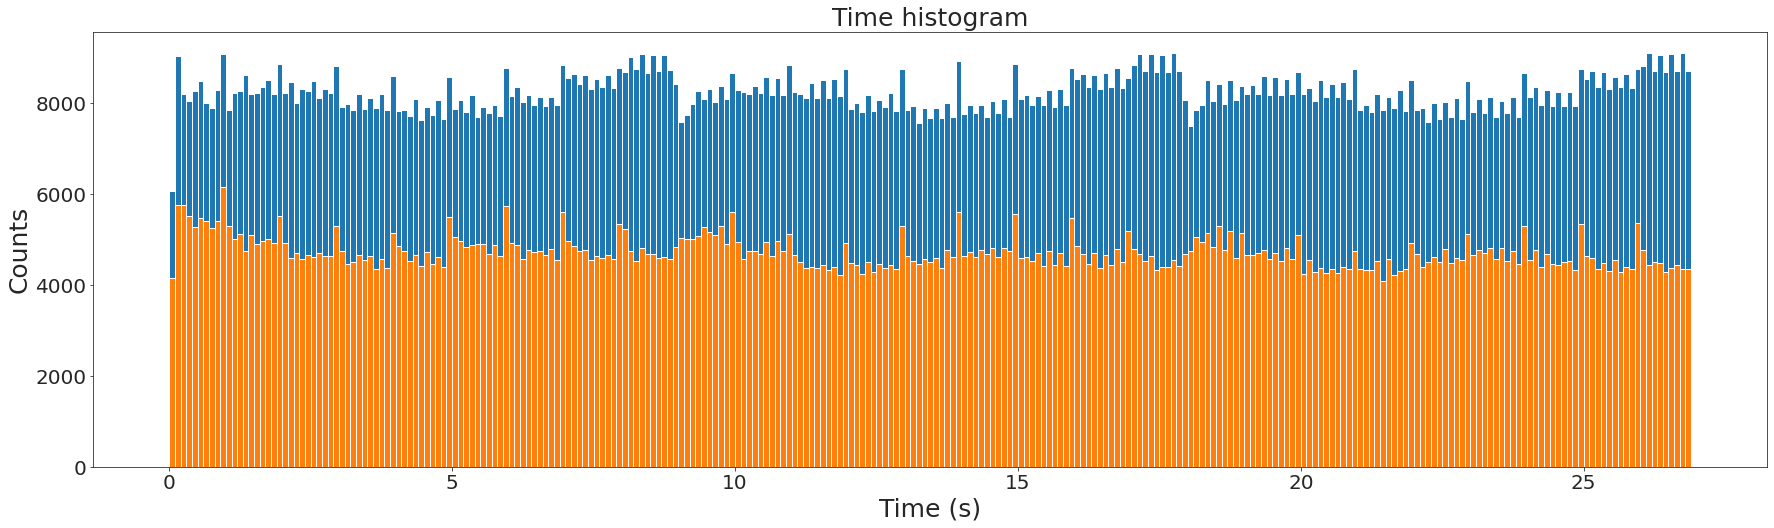

/home/thomas/miniconda3/envs/neuvisys-analysis/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 38 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


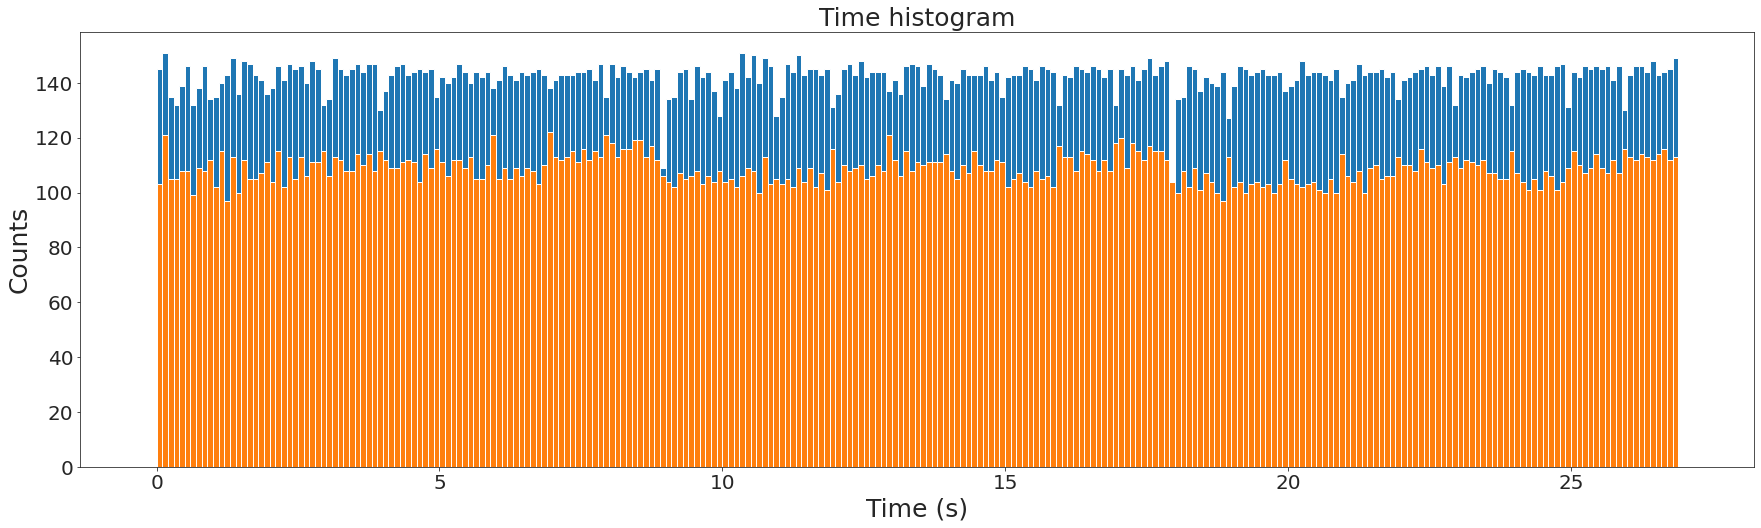

In [12]:
from elephant import statistics
import quantities as pq
from viziphant.statistics import plot_time_histogram

network_path1 = "/home/thomas/Desktop/Experiment/network_control/"
network_path2 = "/home/thomas/Desktop/Experiment/network_experiment/"

spinet = SpikingNetwork(network_path1)
sts = spike_trains(spinet.spikes[0])

fig, axes = plt.subplots()
histogram = statistics.time_histogram(sts, bin_size=100 * pq.ms)
plot_time_histogram(histogram, units='s', axes=axes)

spinet = SpikingNetwork(network_path2)
sts = spike_trains(spinet.spikes[0])

histogram = statistics.time_histogram(sts, bin_size=100 * pq.ms)
plot_time_histogram(histogram, units='s', axes=axes)

axes.set_title("Time histogram")
plt.show()

spinet = SpikingNetwork(network_path1)
sts = spike_trains(spinet.spikes[1])

fig, axes = plt.subplots()
histogram = statistics.time_histogram(sts, bin_size=100 * pq.ms)
plot_time_histogram(histogram, units='s', axes=axes)

spinet = SpikingNetwork(network_path2)
sts = spike_trains(spinet.spikes[1])

histogram = statistics.time_histogram(sts, bin_size=100 * pq.ms)
plot_time_histogram(histogram, units='s', axes=axes)

axes.set_title("Time histogram")
plt.show()